2026-02-27 02:11:47 | INFO | load_relational_data.py::load_organizations | Loading organizations from: E:\Job-Related-Repos\intelligent-device-health-monitoring-system\data\raw\organization\organization.csv
2026-02-27 02:11:47 | INFO | load_relational_data.py::load_device_classes | Loading device_classes from: E:\Job-Related-Repos\intelligent-device-health-monitoring-system\data\raw\device_class\device_class.csv
2026-02-27 02:11:47 | INFO | load_relational_data.py::load_assets | Loading assets from: E:\Job-Related-Repos\intelligent-device-health-monitoring-system\data\raw\asset\assets.csv
2026-02-27 02:11:47 | INFO | load_relational_data.py::load_devices | Loading devices from: E:\Job-Related-Repos\intelligent-device-health-monitoring-system\data\raw\device\devices.csv
2026-02-27 02:11:47 | INFO | load_relational_data.py::load_interfaces | Loading interfaces from: E:\Job-Related-Repos\intelligent-device-health-monitoring-system\data\raw\interface\interfaces.csv
2026-02-27 02:11:48 | IN

--- Organizations ---


,organization_id,org_name,org_industry,num_assets
0,1,Robinson-Sims,Social worker,4
1,2,"Oliver, Mclaughlin and Bryant",Airline pilot,1
2,3,"Gregory, Smith and Wilson",Actor,2
3,4,"Hays, Wright and Riddle","Investment banker, corporate",2
4,5,Grant-Weiss,Microbiologist,2


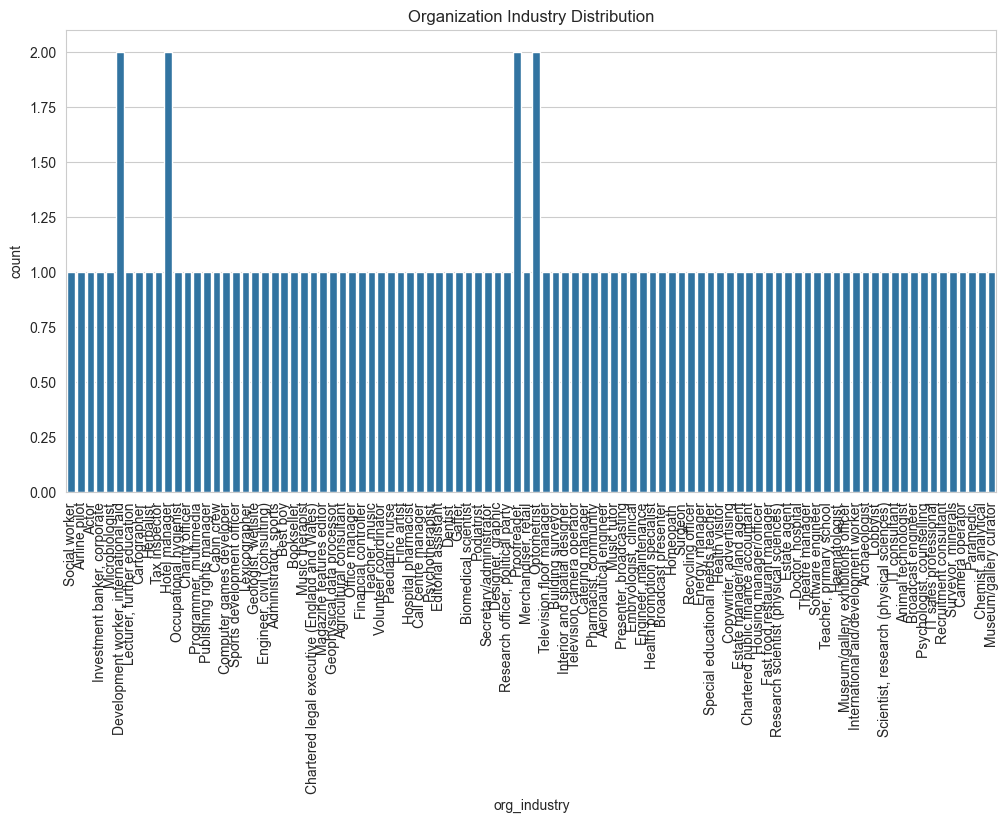

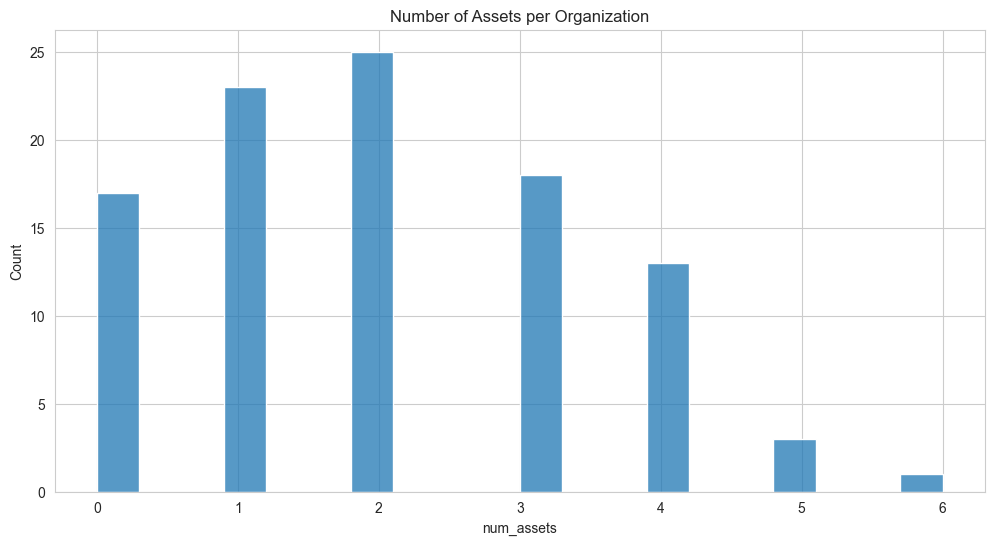

,asset_id,asset_name,organization_id,asset_location,asset_owner,asset_purchase_date,num_devices
0,1,db-71.smith.com,62,East Garychester,Christina Casey,2025-07-02,50
1,2,db-35.lee.com,86,West Jenna,Robin Miller,2022-10-17,71
2,3,email-52.griffith.com,40,Lake Albertville,Brianna Dominguez,2023-11-10,48
3,4,laptop-78.sosa-harris.com,76,Perkinsstad,Linda Johnson,2023-02-20,47
4,5,lt-99.willis.com,7,Jasonton,Bobby Phillips,2023-07-18,45


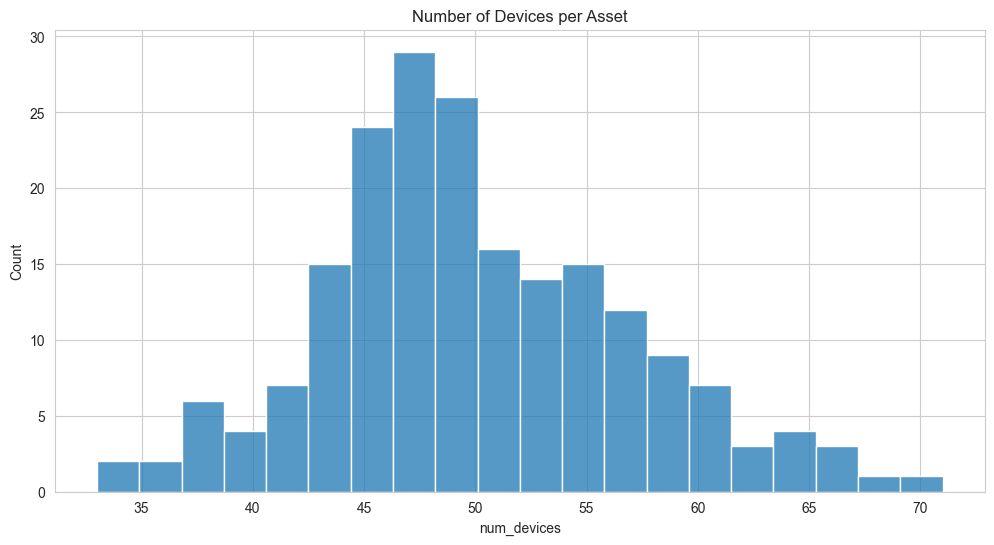

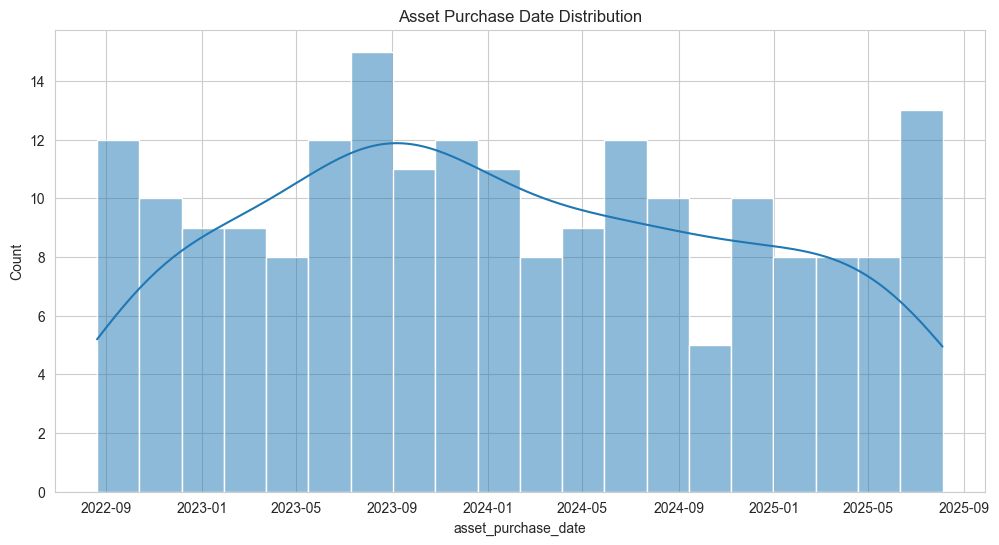

,device_class_id,device_class_name,num_devices
0,1,Human Class,221
1,2,Role Class,204
2,3,Exactly Class,193
3,4,Action Class,202
4,5,East Class,199


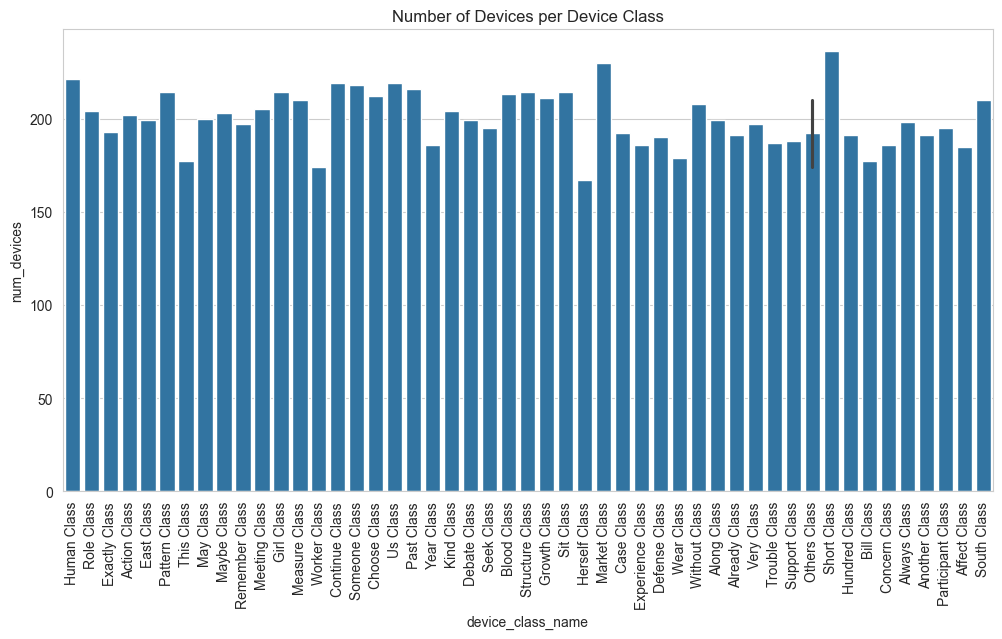

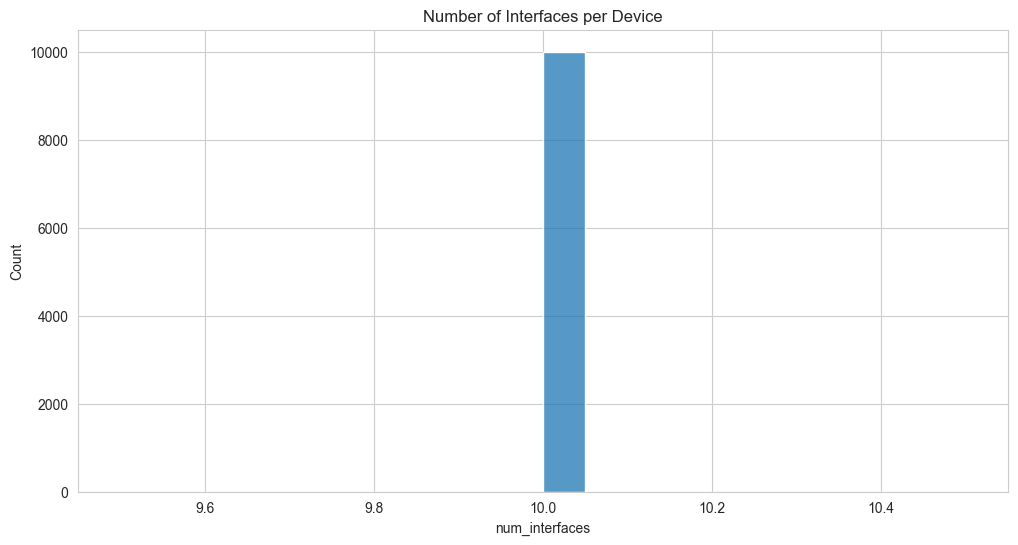

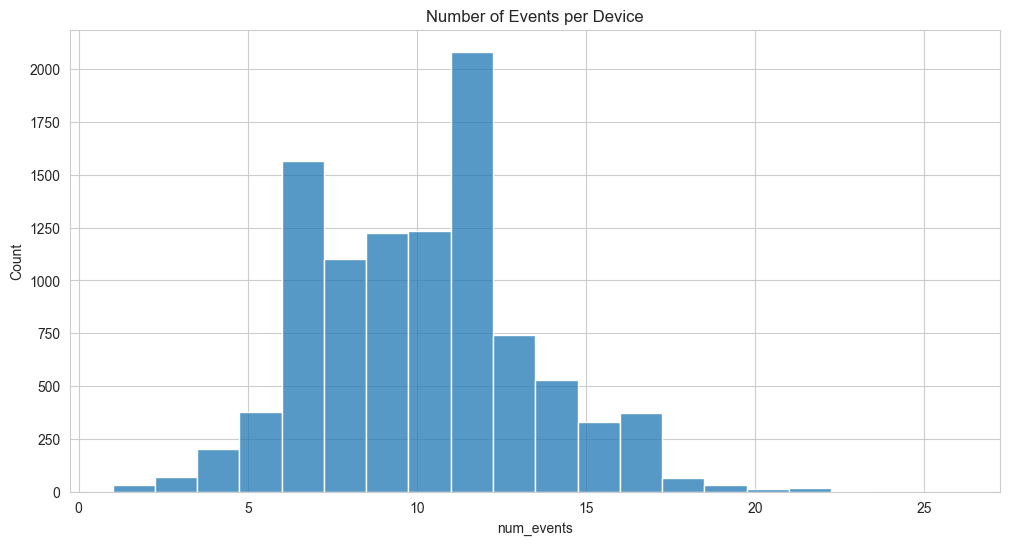

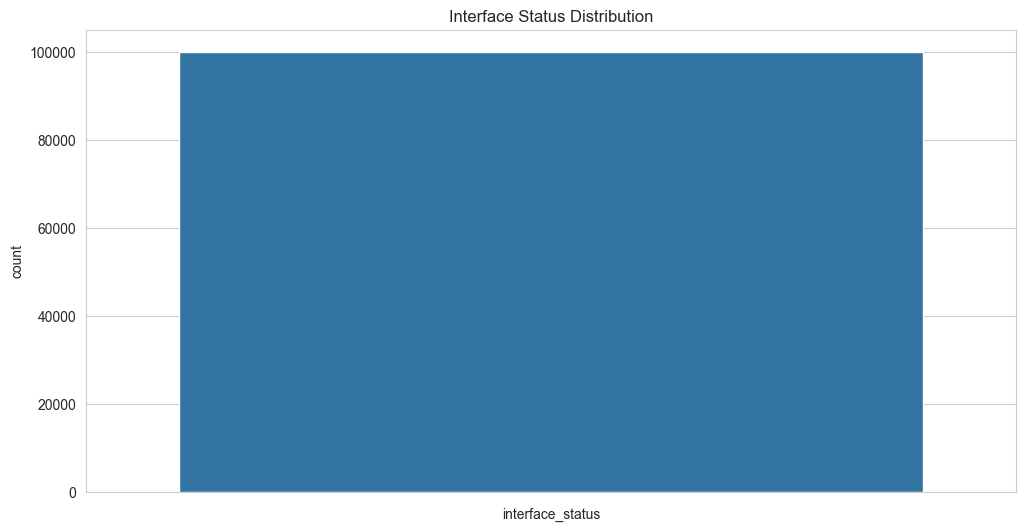

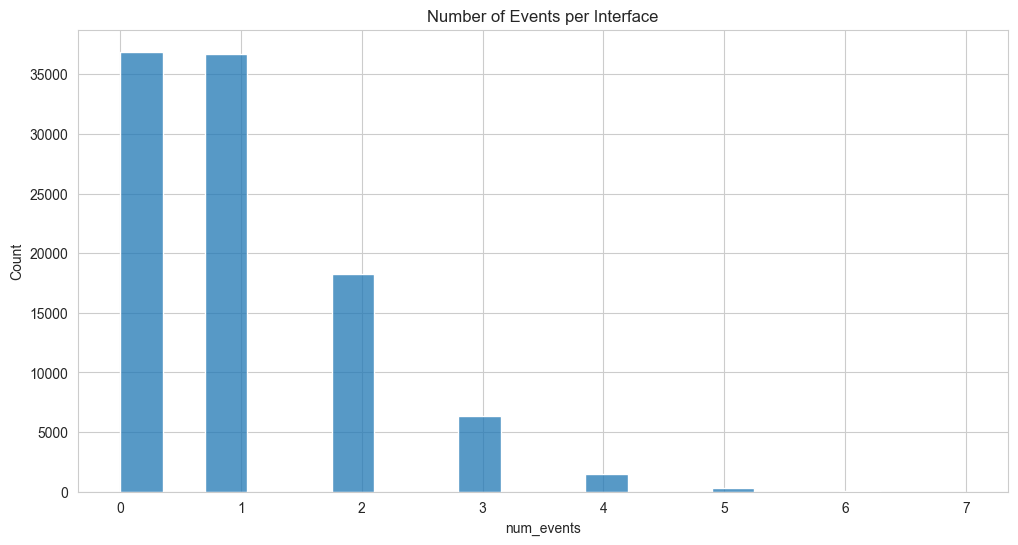

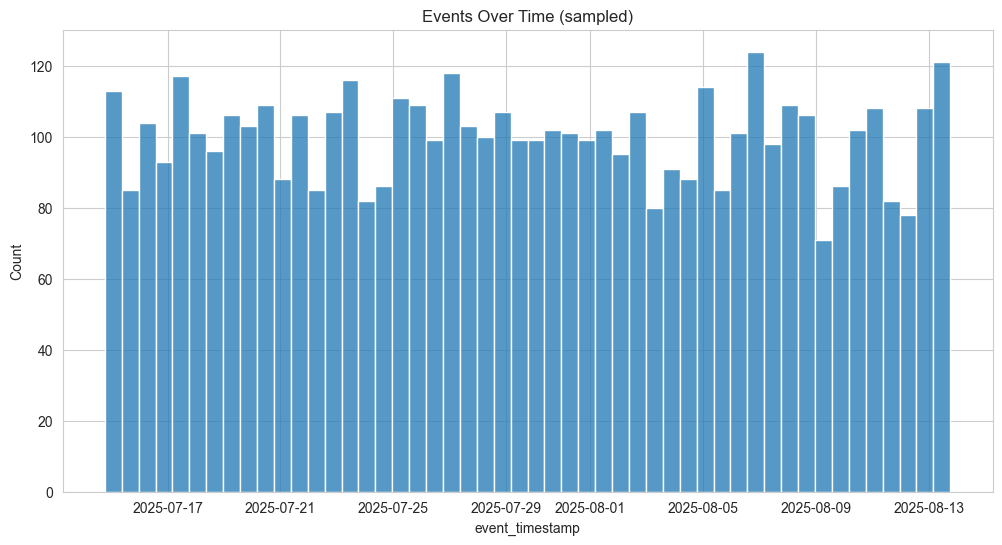

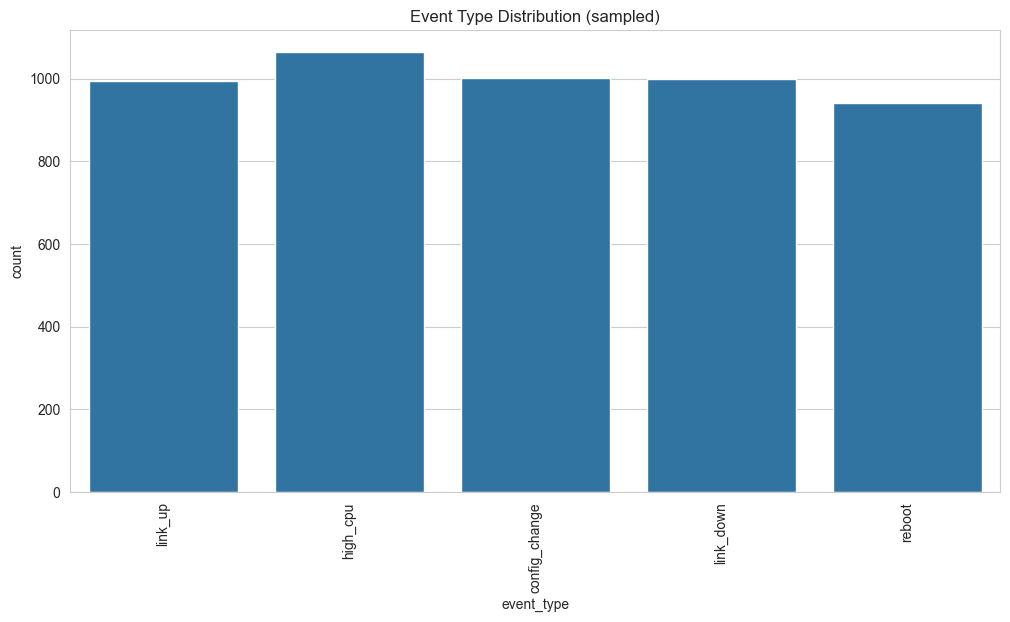

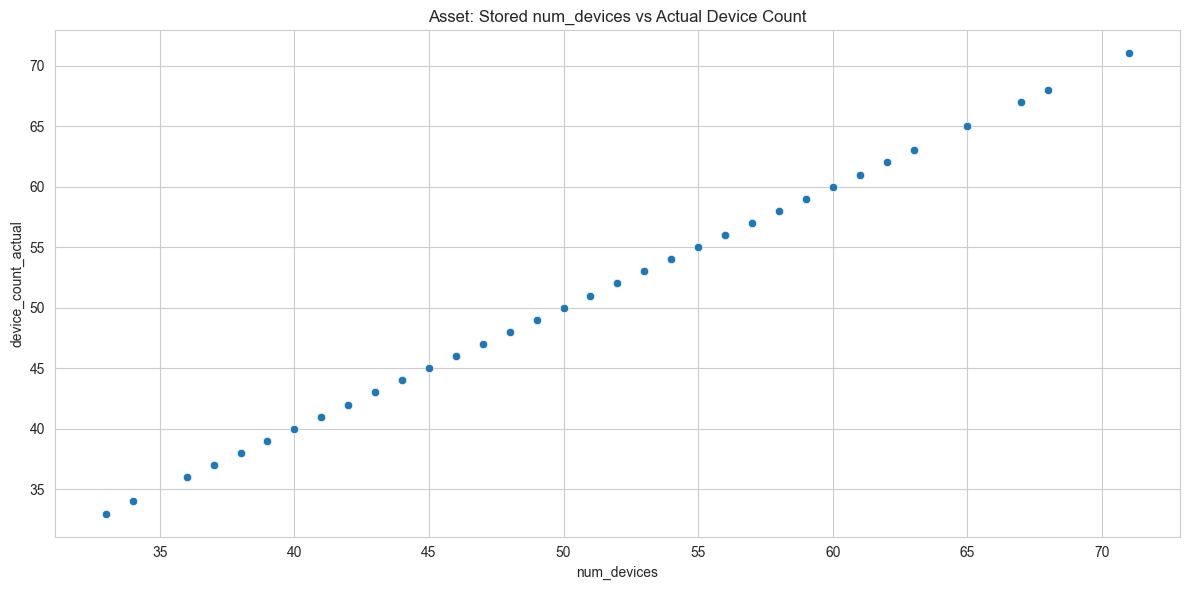

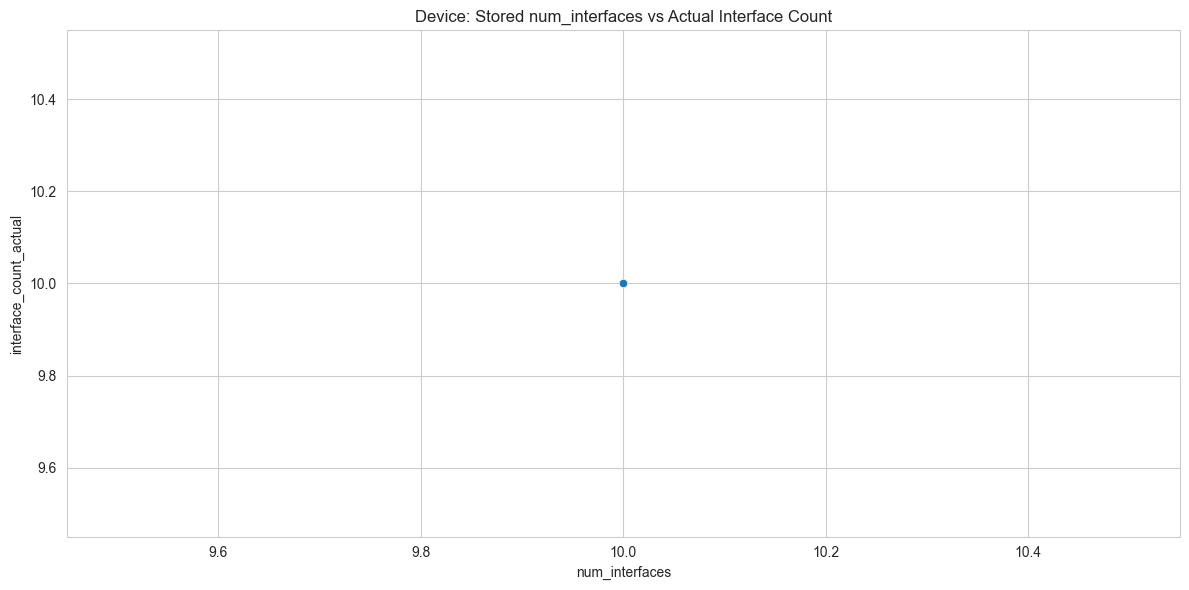

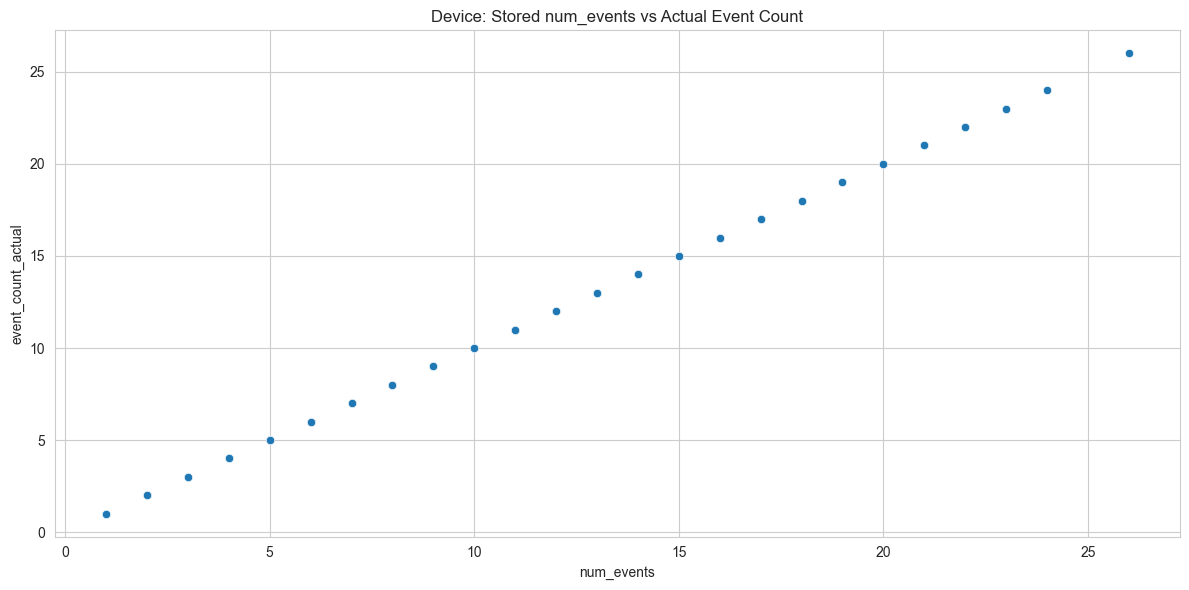

In [1]:
# notebooks/exploratory_analysis.ipynb

# -------------------------------------------------------
# Exploratory Data Analysis (EDA)
# Intelligent Device Health Monitoring System
# Memory-Efficient Version
# -------------------------------------------------------

# -----------------------
# 1. Introduction
# -----------------------
"""
This notebook provides a complete exploratory analysis of the Intelligent Device Health Monitoring System project.
We aim to understand the relationships between:

1. **Organizations**: Each organization owns multiple assets.
2. **Assets**: Each asset may have multiple devices.
3. **Device Classes**: Devices belong to a specific device class.
4. **Devices**: Each device may have multiple interfaces and generate multiple events.
5. **Interfaces**: Each interface belongs to a device and can generate events.
6. **Events**: Linked to a device and optionally to an interface.

Approach:
- Load relational data using the centralized loader (`load_all_data()`).
- Preserve all entity relationships.
- Use a **subset of data for plotting** to save memory.
- Compute **full aggregates efficiently** without loading all events into memory.
- Maximize insights with minimum data usage (“middle class family” approach).
"""

# -----------------------
# 2. Imports & Setup
# -----------------------
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
REPO_ROOT = Path("../")  # adjust if running from notebooks/
RAW_DATA_DIR = REPO_ROOT / "data" / "raw"

# Add src to path
SRC_PATH = REPO_ROOT / "src"
sys.path.append(str(SRC_PATH))

# Load relational loader
from transformation.load_relational_data import load_all_data

# Plotting aesthetics
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# -----------------------
# 3. Load Data (Full for relationships, subset for plotting)
# -----------------------
# Full object graph (relationships preserved)
db = load_all_data()

# Extract entities
organizations = db['organizations']
assets = db['assets']
devices = db['devices']
device_classes = db['device_classes']
interfaces = db['interfaces']
events = db['events']

# -----------------------
# 4. Convert to DataFrames (for aggregation and plotting)
# -----------------------
# Organizations
org_df = pd.DataFrame([{
    "organization_id": o.organization_id,
    "org_name": o.org_name,
    "org_industry": o.org_industry,
    "num_assets": len(o.assets)
} for o in organizations.values()])

# Assets
asset_df = pd.DataFrame([{
    "asset_id": a.asset_id,
    "asset_name": a.asset_name,
    "organization_id": a.organization.organization_id if a.organization else None,
    "asset_location": a.asset_location,
    "asset_owner": a.asset_owner,
    "asset_purchase_date": a.asset_purchase_date,
    "num_devices": len(a.devices)
} for a in assets.values()])
asset_df["asset_purchase_date"] = pd.to_datetime(asset_df["asset_purchase_date"])

# Devices
device_df = pd.DataFrame([{
    "device_id": d.device_id,
    "device_ip": d.device_ip,
    "device_serial": d.device_serial,
    "device_manufacturer": d.device_manufacturer,
    "asset_id": d.asset.asset_id if d.asset else None,
    "device_class_id": d.device_class.device_class_id if d.device_class else None,
    "num_interfaces": len(d.interfaces),
    "num_events": len(d.events)
} for d in devices.values()])

# Device Classes
device_class_df = pd.DataFrame([{
    "device_class_id": dc.device_class_id,
    "device_class_name": dc.device_class_name,
    "num_devices": len(dc.devices)
} for dc in device_classes.values()])

# Interfaces
interface_df = pd.DataFrame([{
    "interface_id": i.interface_id,
    "interface_name": i.interface_name,
    "device_id": i.device.device_id if i.device else None,
    "interface_status": i.interface_status,
    "num_events": len(i.events)
} for i in interfaces.values()])

# Events (subset for plotting)
event_sample_size = 5000  # middle-class memory usage
event_df_full = pd.DataFrame([{
    "event_id": e.event_id,
    "event_timestamp": e.event_timestamp,
    "device_id": e.device.device_id if e.device else None,
    "interface_id": e.interface.interface_id if e.interface else None,
    "event_type": e.event_type,
    "event_description": e.event_description
} for e in events.values()])

event_df = event_df_full.sample(n=min(event_sample_size, len(event_df_full)), random_state=42)
event_df["event_timestamp"] = pd.to_datetime(event_df["event_timestamp"])

# -----------------------
# 5. EDA - Organizations
# -----------------------
print("--- Organizations ---")
display(org_df.head())

sns.countplot(data=org_df, x="org_industry")
plt.title("Organization Industry Distribution")
plt.xticks(rotation=90)
plt.show()

sns.histplot(org_df["num_assets"], bins=20)
plt.title("Number of Assets per Organization")
plt.show()

# -----------------------
# 6. EDA - Assets
# -----------------------
display(asset_df.head())

sns.histplot(asset_df["num_devices"], bins=20)
plt.title("Number of Devices per Asset")
plt.show()

sns.histplot(asset_df["asset_purchase_date"].dropna(), bins=20, kde=True)
plt.title("Asset Purchase Date Distribution")
plt.show()

# -----------------------
# 7. EDA - Device Classes & Devices
# -----------------------
display(device_class_df.head())

sns.barplot(data=device_class_df, x="device_class_name", y="num_devices")
plt.xticks(rotation=90)
plt.title("Number of Devices per Device Class")
plt.show()

sns.histplot(device_df["num_interfaces"], bins=20)
plt.title("Number of Interfaces per Device")
plt.show()

sns.histplot(device_df["num_events"], bins=20)
plt.title("Number of Events per Device")
plt.show()

# -----------------------
# 8. EDA - Interfaces
# -----------------------
sns.countplot(data=interface_df, x="interface_status")
plt.title("Interface Status Distribution")
plt.show()

sns.histplot(interface_df["num_events"], bins=20)
plt.title("Number of Events per Interface")
plt.show()

# -----------------------
# 9. EDA - Events (subset for plotting)
# -----------------------
sns.histplot(event_df["event_timestamp"], bins=50)
plt.title("Events Over Time (sampled)")
plt.show()

sns.countplot(data=event_df, x="event_type")
plt.title("Event Type Distribution (sampled)")
plt.xticks(rotation=90)
plt.show()

# -----------------------
# 10. Relationships (aggregates)
# -----------------------

# ------------------
# Assets → Devices
# ------------------
asset_device_counts = (
    device_df
    .groupby("asset_id")["device_id"]
    .count()
    .reset_index()
    .rename(columns={"device_id": "device_count_actual"})
)

merged_asset = asset_df.merge(
    asset_device_counts,
    on="asset_id",
    how="left"
)

merged_asset["device_count_actual"] = merged_asset["device_count_actual"].fillna(0)

sns.scatterplot(
    data=merged_asset,
    x="num_devices",
    y="device_count_actual"
)
plt.title("Asset: Stored num_devices vs Actual Device Count")
plt.tight_layout()
plt.show()


# ------------------
# Devices → Interfaces
# ------------------
device_interface_counts = (
    interface_df
    .groupby("device_id")["interface_id"]
    .count()
    .reset_index()
    .rename(columns={"interface_id": "interface_count_actual"})
)

merged_device = device_df.merge(
    device_interface_counts,
    on="device_id",
    how="left"
)

merged_device["interface_count_actual"] = merged_device["interface_count_actual"].fillna(0)

sns.scatterplot(
    data=merged_device,
    x="num_interfaces",
    y="interface_count_actual"
)
plt.title("Device: Stored num_interfaces vs Actual Interface Count")
plt.tight_layout()
plt.show()


# ------------------
# Devices → Events
# ------------------
device_event_counts = (
    event_df_full
    .groupby("device_id")["event_id"]
    .count()
    .reset_index()
    .rename(columns={"event_id": "event_count_actual"})
)

merged_device_event = device_df.merge(
    device_event_counts,
    on="device_id",
    how="left"
)

merged_device_event["event_count_actual"] = merged_device_event["event_count_actual"].fillna(0)

sns.scatterplot(
    data=merged_device_event,
    x="num_events",
    y="event_count_actual"
)
plt.title("Device: Stored num_events vs Actual Event Count")
plt.tight_layout()
plt.show()

# -----------------------
# 11. Optional: Save Snapshots
# -----------------------
processed_dir = REPO_ROOT / "data" / "processed"
asset_df.to_csv(processed_dir / "assets_snapshot.csv", index=False)
device_df.to_csv(processed_dir / "devices_snapshot.csv", index=False)
event_df.to_csv(processed_dir / "events_snapshot_sample.csv", index=False)